<a target="_blank" href="https://colab.research.google.com/github/evaalonsoortiz/ELE8812-demos/blob/main/Demos/Lesson%208/Leçon_8_Demo_1DSignalDecomposition.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ELE8812 - Multirésolution

## Démo : Décomposition de signal 1D

### Référence: DIP 4e édition, Chapitre 7, « Wavelet Transforms » p.504

Dans ce démo, un signal 1D sera développé en série d’ondelettes puis reconstruit. Une comparaison avec le développement en série de Fourier sera d’abord effectuée.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 3

from ipywidgets import interactive, fixed
from scipy.interpolate import interp1d
import pywt

## Signal à décomposer

\begin{equation}
f(x) = x^2, \text{ pour } x \in [0, 1]
\end{equation}

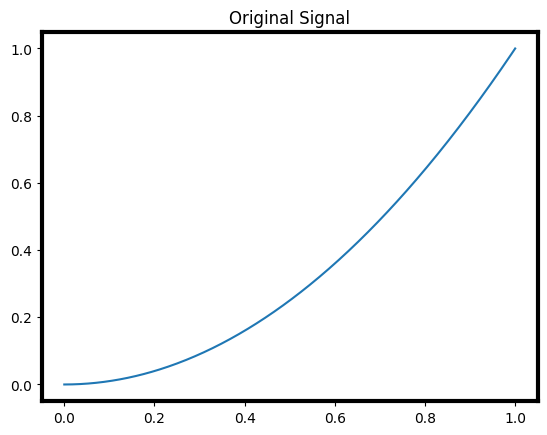

In [10]:
x = np.linspace(0, 1, 512);
y = x**2
plt.plot(x,y); plt.title('Original Signal')
plt.show()

# Définition

## Développement d'un signal en séries

\begin{equation}
f(x) = \sum_k \alpha_k \phi_k(x)
\end{equation}

où $\alpha_k$ sont les coefficients d'expansion et $\phi_k(x)$ sont les fonctions d'expansion.

### Coefficients d'expansion

Si $\{\phi_k(x)\}$ forme une base orthogonale, les $\alpha_k$ sont obtenus en calculant l'intégral du produit scalaire de la base $\phi_k(x)$ et les fonctions $f(x)$

\begin{equation}
\alpha_k = \langle\phi_k(x), f(x)\rangle = \int\phi^*_k(x) f(x) dx
\end{equation}

# Exemple 1: Transformée de Fourier 1D

Pour le développement en série de Fourier, les fonctions d'expansion sont données par:


\begin{equation}
\phi_k(x) = e^{2 i \pi k x / T}
\end{equation}

In [11]:
k = 4
def phi_fourier(x, k):
    phi = np.exp(2.0j * np.pi * k * x)
    return phi

def plot_fourier_functions(k):
    plt.figure(figsize=(8,5))
    plt.plot(x, phi_fourier(x, k).real, label='Real part')
    plt.plot(x, phi_fourier(x, k).imag, label='Imaginary part')
    plt.title('Fourier basis function $\phi_k(x)$ for k={}'.format(k), y=1.05)
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1]); plt.xlabel('x')
    plt.ylim([-1.5, 1.5]); plt.ylabel('y')
    plt.legend(loc=1)
    plt.show()

Les fonctions de base de la série de Fourier sont des sinus et cosinus. Lorsque que la variable `k` augmente, la fréquence d’oscillation des fonctions de bases augmente également.

In [12]:
interactive(plot_fourier_functions, k=(0,16))

interactive(children=(IntSlider(value=8, description='k', max=16), Output()), _dom_classes=('widget-interact',…

## Calcul des coefficients d'expansion

In [13]:
coeffs = dict()
nLevels = 10
for k in range(-nLevels, nLevels + 1):
    alpha = np.sum(y * np.conj(phi_fourier(x, k)))
    coeffs['a_{}'.format(k)] = alpha

In [20]:
def plot_reconstruction_fourier(x, y, coeffs, max_level=-1):
    if max_level == -1:
        max_level = (len(coeffs) - 1) / 2

    signal = None
    plt.figure(figsize=(8,5))
    for k in range(-max_level, max_level+1):
        alpha = coeffs['a_{}'.format(k)]
        phi = alpha * phi_fourier(x, k) / float(len(x))
        if signal is None:
            signal = phi
        else:
            signal += phi
        if k == max_level:
            label=r"$\alpha_k \phi_k(x)$"
        else:
            label = None
        plt.plot(x, phi.real, color=[0.2, 0.2, 1.0], alpha=0.5, label=label, linewidth=5)

    plt.plot(x, y, color='k', label=r'$f(x)$')
    plt.plot(x, signal.real, color='r', label=r'$\frac{1}{N}\sum_k \alpha_k \phi_k(x)$')
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1]); plt.xlabel('x')
    plt.legend()
    plt.title(r"$|k| \leq %d$" % max_level, y=1.04)
    plt.show()

Dans ce graphique, la courbe noire est le signal original et les courbes bleues correspondent à la multiplication de la fonction génératrice et de son coefficient pour chaque `k`. La courbe rouge est la somme de toutes les courbes bleues. Pour `k` = 0, la fonction génératrice correspond à $y = 1$ et le coefficient 0 est la moyenne du signal (*dc component*), ce qui explique qu’une ligne horizontale est obtenue en $y =$ mean(signal).
À mesure que le nombre de niveau `k` augmente, l’approximation du signal original devient meilleure. Or, même avec `k` = 10, l’approximation n’est pas parfaite, surtout aux extrémités du signal.


In [23]:
interactive(plot_reconstruction_fourier, x = fixed(x), y=fixed(y), coeffs=fixed(coeffs), max_level=(0,nLevels))

interactive(children=(IntSlider(value=0, description='max_level', max=10), Output()), _dom_classes=('widget-in…

# Transformée en ondelettes

## Fonctions d'échelle

In [54]:
def get_scalingFunction(a, b, wavelet='haar', nSupport=1):
    phi_0, psi_0, x_0 = pywt.DiscreteContinuousWavelet(wavelet).wavefun(level=8)
    f = interp1d(x_0, phi_0, kind='linear', fill_value=0, bounds_error=False)
    w = x_0[-1] - x_0[0]
    xmin = x_0[0] - nSupport*w
    xmax = x_0[-1] + nSupport*w
    nSteps = int((2*nSupport + 1) * len(x_0))
    #x = np.linspace(xmin, xmax, nSteps)
    x = np.linspace(-5, 5, nSteps)
    phi = 2**(a/2.0)*f(2**a*x - b)
    return phi, x

def display_scalingFunction(j_scale=0,k_translate=0,wavelet='haar', show = True):
    phi, x = get_scalingFunction(j_scale, k_translate, wavelet)
    plt.fill_between(x, phi);
    plt.plot(x, phi, color='k');
    plt.axhline(0, color='k', alpha=0.5)
    plt.axvline(0, color='k', alpha=0.5)
    plt.xticks(np.linspace(-5, 5, 11))
    plt.title(r'$\varphi_{%d,%d}(x)$' % (j_scale, k_translate), y=1.05)
    if show:
      plt.show()

Les fonctions d’échelle sont utilisées pour créer une série d’approximation d’une fonction, chacune ayant une résolution différant par un facteur de 2. Pour tous les types d’ondelettes, l’augmentation de l’échelle `j` diminue la largeur de la fonction d’échelle. Avec l’ondelette de Haar on peut bien voir que la largeur est de 1 pour `j` = 0 et de 0.5 pour `j` = 1. Avec `j` =0, une translation de 1 entraîne un déplacement de +1, tandis qu’avec `j`=1, une translation de +1 entraîne un déplacement de + 0.5.


In [55]:
waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']
interactive(display_scalingFunction, j_scale=(0,4), k_translate=(-5,4), wavelet=waveletList)

interactive(children=(IntSlider(value=0, description='j_scale', max=4), IntSlider(value=0, description='k_tran…

## Fonctions d'ondelettes

In [56]:
def get_waveletFunction(a, b, wavelet='haar', nSupport=1):
    phi_0, psi_0, x_0 = pywt.DiscreteContinuousWavelet(wavelet).wavefun(level=8)
    f = interp1d(x_0, psi_0, kind='linear', fill_value=0, bounds_error=False)
    w = x_0[-1] - x_0[0]
    xmin = x_0[0] - nSupport*w
    xmax = x_0[-1] + nSupport*w
    nSteps = int((2*nSupport + 1) * len(x_0))
    #x = np.linspace(xmin, xmax, nSteps)
    x = np.linspace(-5, 5, nSteps)
    psi = 2**(a/2.0)*f(2**a*x - b)
    return psi, x

def display_waveletFunction(j_scale=0,k_translate=0,wavelet='haar'):
    psi, x = get_waveletFunction(j_scale, k_translate, wavelet)
    plt.fill_between(x, psi);
    plt.plot(x, psi, color='k');
    plt.axhline(0, color='k', alpha=0.5)
    plt.axvline(0, color='k', alpha=0.5)
    plt.xticks(np.linspace(-5, 5, 11))
    plt.title(r'$\psi_{%d,%d}(x)$' % (j_scale, k_translate), y=1.05)
    plt.show()

Les fonctions d’ondelettes sont utilisées pour encoder la différence entre 2 approximations adjacentes des fonctions d’échelles. L’effet du changement d’échelle `j` et de la translation est le même que pour les fonctions d’échelle.

In [57]:
waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']
interactive(display_waveletFunction, j_scale=(0,4), k_translate=(-10,10), wavelet=waveletList)

interactive(children=(IntSlider(value=0, description='j_scale', max=4), IntSlider(value=0, description='k_tran…

## Exemple 2 : Décomposition par les ondelettes de Haar

\begin{equation}
f(x) = \sum_{k} c_{j_0}(k) \varphi_{j_0,k}(x) + \sum_{j\geq j_0}\sum_{k} d_j(x)\psi_{j,k}(x)
\end{equation}

**Coefficients d'échelle**
\begin{equation}
c_{j_0}(k) = \langle f(x), \varphi_{j_0,l}(x)\rangle = \int f(x) \varphi^*_{j_0, k}(x) dx
\end{equation}

**Coefficients d'ondelettes**
\begin{equation}
d_{j}(k) = \langle f(x), \psi_{j,l}(x)\rangle = \int f(x) \psi^*_{j, k}(x) dx
\end{equation}

## Signal original, fonctions d'échelle et ondelettes de Haar

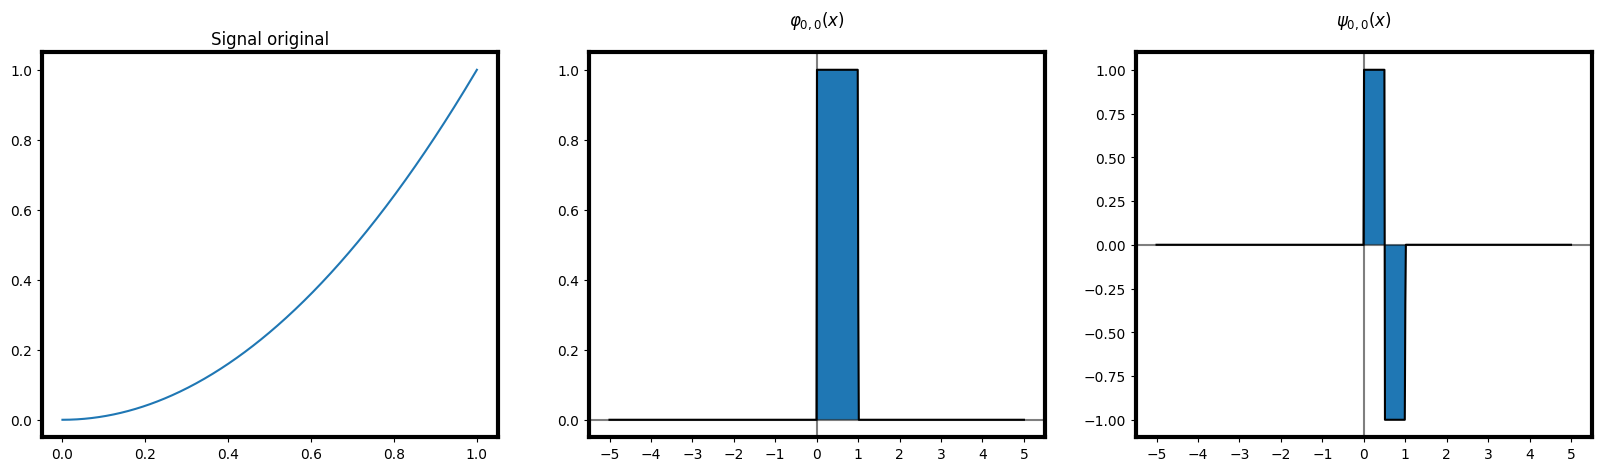

In [58]:
plt.figure(figsize=(20,5))
j = 0; k = 0;
plt.subplot(131); plt.plot(x,y); plt.title('Signal original')
plt.subplot(132); display_scalingFunction(j,k, show = False)
plt.subplot(133); display_waveletFunction(j,k)

In [61]:
## Wavelet decomposition and reconstruction
def plot_reconstruction_haar(x, y, wavelet = 'haar', level=0):
    coeffs = pywt.wavedec(y, wavelet)
    signal = None
    plt.figure(figsize=(8,5))
    coeffs_recons = list()
    for k in range(len(coeffs)):
        if k > level+1:
            coeffs_recons.append(np.zeros(len(coeffs[k])))
        else:
            coeffs_recons.append(coeffs[k])
    signal = pywt.waverec(coeffs_recons, wavelet)
    plt.plot(x, y, color='k', label=r'$f(x)$')
    plt.plot(x, signal, color='r', label=r'$\frac{1}{N}\sum_k \alpha_k \phi_k(x)$')
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1]); plt.xlabel('x')
    plt.legend()
    plt.title(r"$|j| \leq %d$" % level, y=1.04)
    plt.show()

La reconstruction avec les ondelettes donne un meilleur résultat qu’avec la série de Fourier (utilisation de sinus/cosinus). La reconstruction est presque parfaite avec les ondelette de Haar et 7 niveaux d’échelle. Tandis qu’avec les ondelettes Daubechies 2 (db2) et Symlets 2 (sym2), une très bonne reconstruction est obtenue avec seulement 2 niveaux d’échelle.

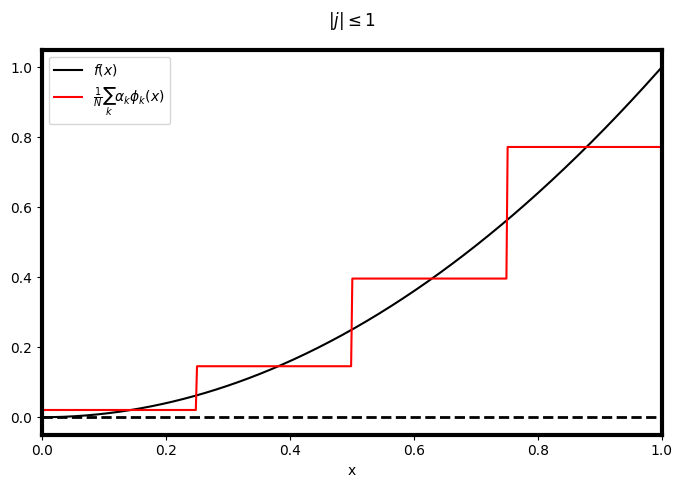

In [62]:
waveletList = ['haar', 'db2', 'sym2']
interactive(plot_reconstruction_haar, x = fixed(x), y=fixed(y), level=(0,8), wavelet=waveletList)